In [1]:
#Resource
#https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%202%20-%20Case%20Studies.ipynb
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
#Resource
#https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%202%20-%20Case%20Studies.ipynb
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

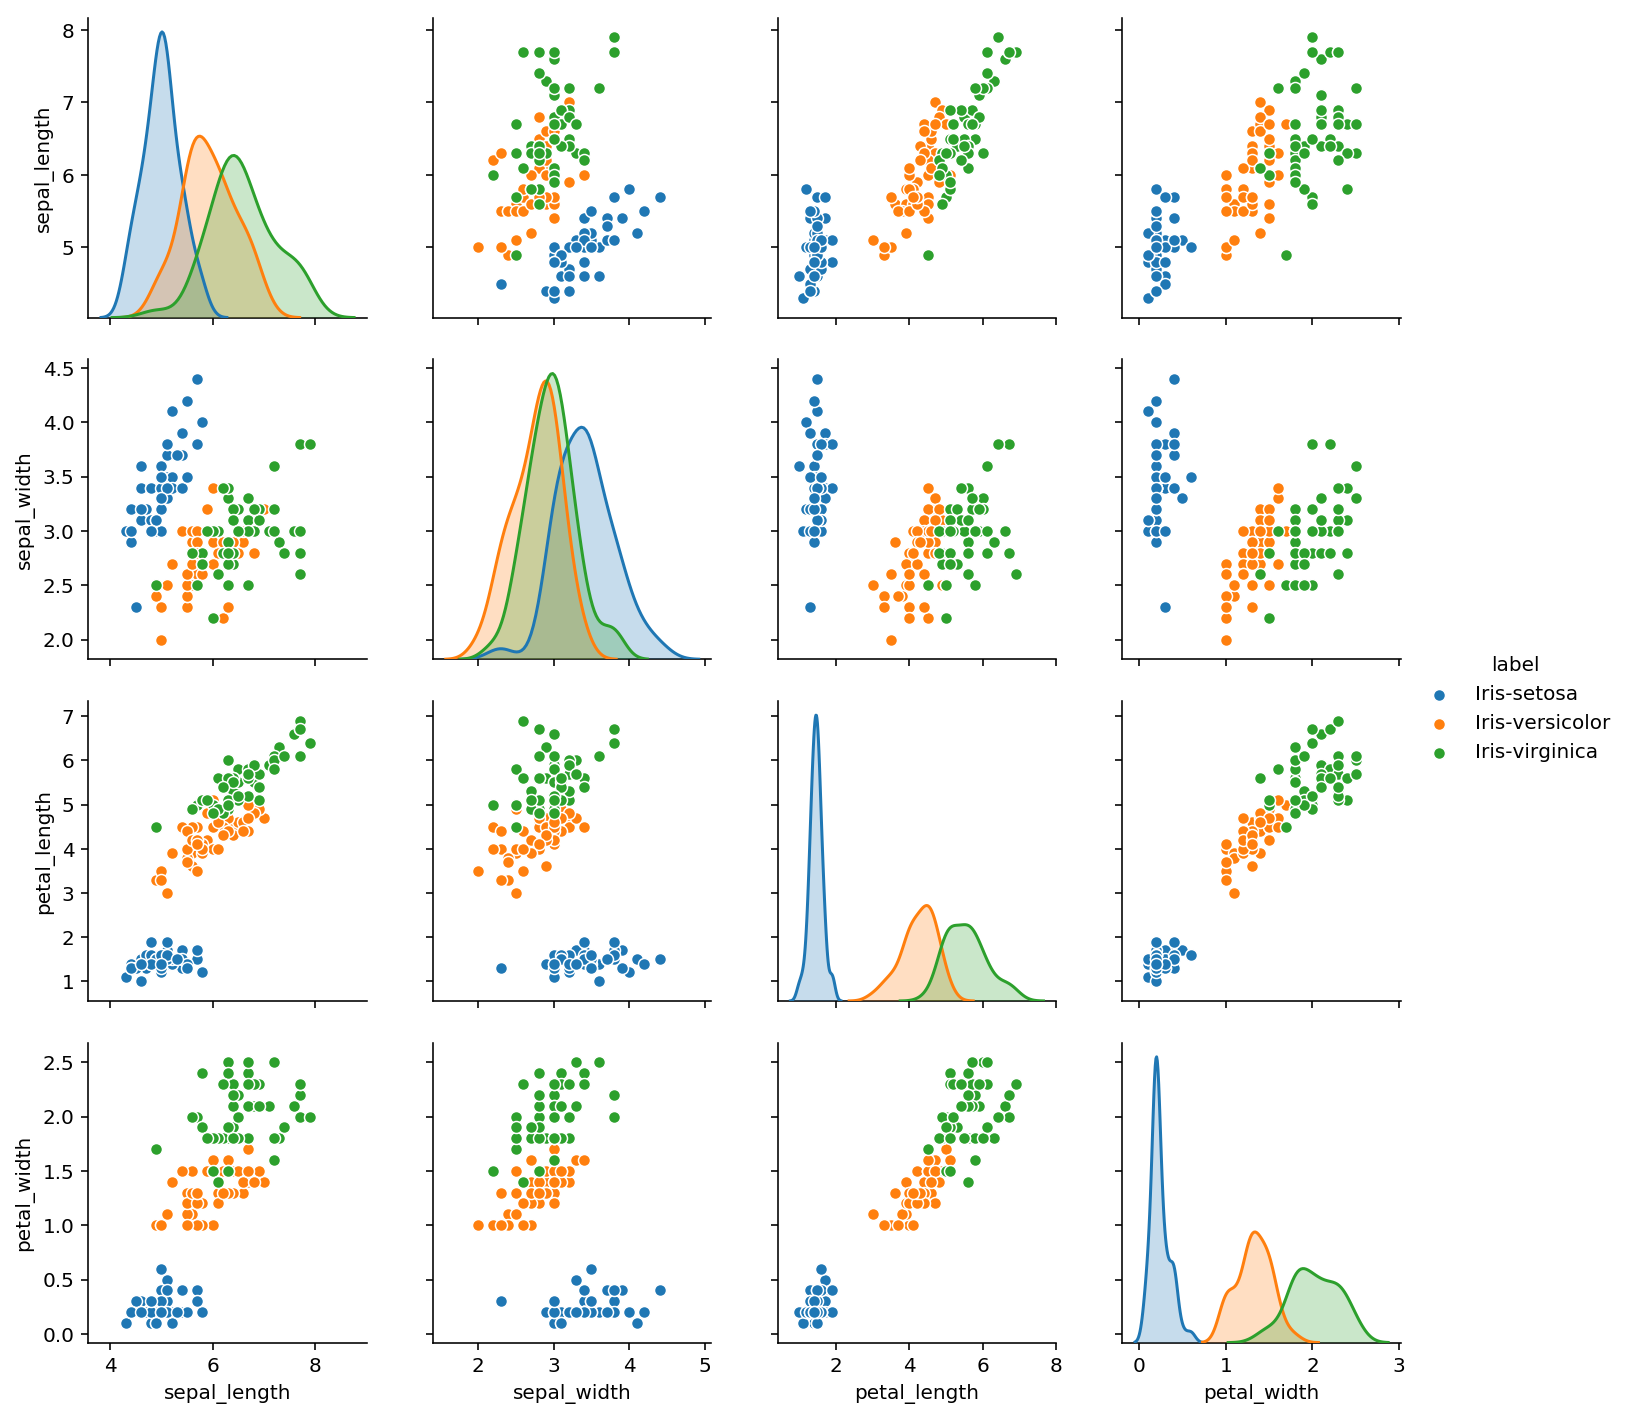

In [37]:
#Load data
dataset=pd.read_csv('C:\\Users\\sagi\\Desktop\\Learning\\ML\\Datasets\\iris.data.txt', names=('sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'),header=None,delimiter=',')
dataset.head()
sns.pairplot(dataset, hue='label') #pairwise distribution of features colored by the class 

In [23]:
#Split data
X=dataset.iloc[:,:4]
y=dataset.iloc[:,4]

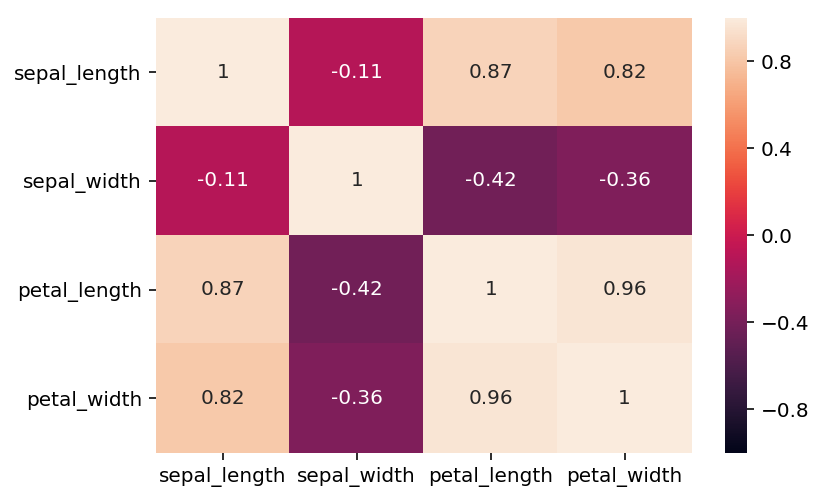

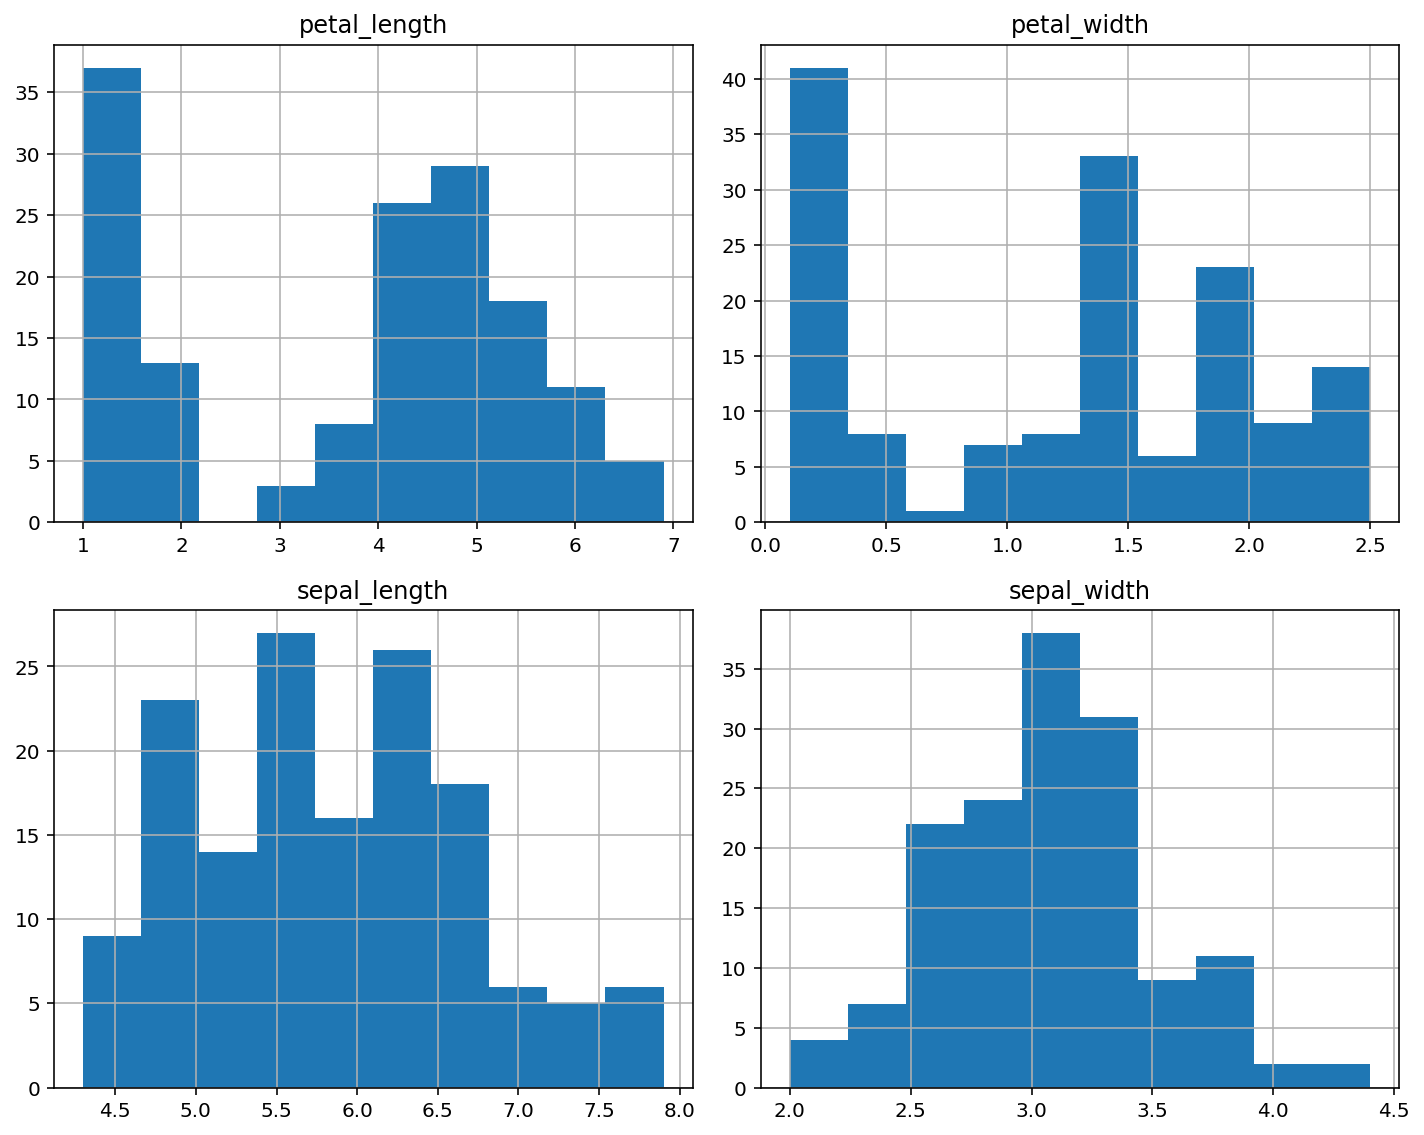

In [42]:
#Exploring data
sns.heatmap(dataset.corr(), annot=True, vmin=-1, vmax=1)
dataset.hist(figsize=(10, 8))
plt.tight_layout()


In [41]:
#Normalizing and transforming y into numerical using one-hot-encoder
ss = StandardScaler()
X = ss.fit_transform(X)
y = pd.get_dummies(dataset['label']).values
print(X.shape, y.shape)

(150, 4) (150, 3)


In [44]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)

(120, 4) (120, 3)


<Figure size 576x432 with 0 Axes>

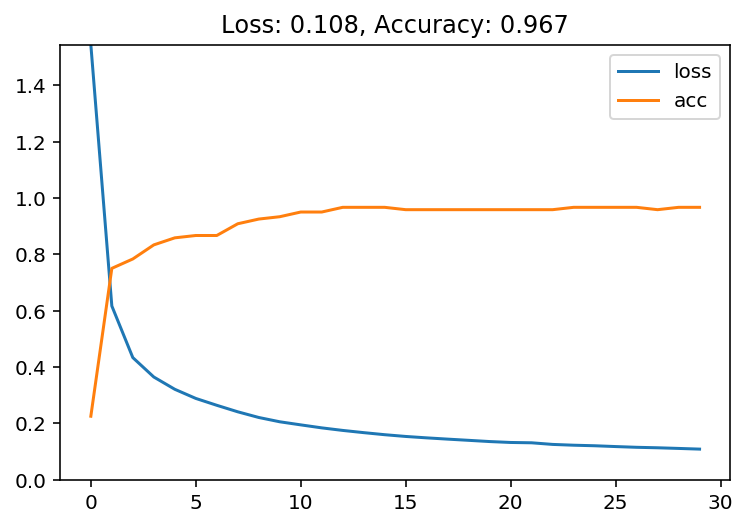

In [45]:
#Softmax Regression Model
sr_model = Sequential()
sr_model.add(Dense(3, input_shape=(X.shape[1],), activation='softmax'))

sr_model.compile(Adam(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

history = sr_model.fit(X_train, y_train, epochs=30, verbose=0)
plot_loss_accuracy(history)

<Figure size 576x432 with 0 Axes>

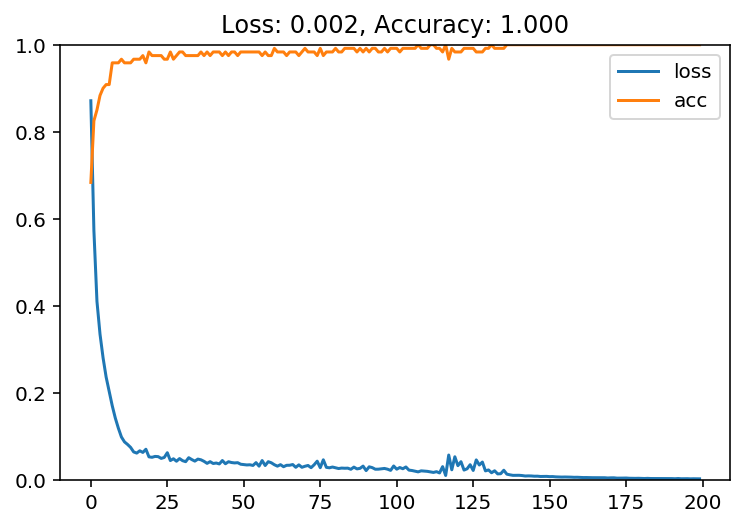

In [61]:
#ANN Model
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(3, activation='softmax'))

deep_model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

history = deep_model.fit(X_train, y_train, epochs=200, verbose=0)
plot_loss_accuracy(history)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.82      1.00      0.90        14
           2       1.00      0.62      0.77         8

   micro avg       0.90      0.90      0.90        30
   macro avg       0.94      0.88      0.89        30
weighted avg       0.92      0.90      0.89        30



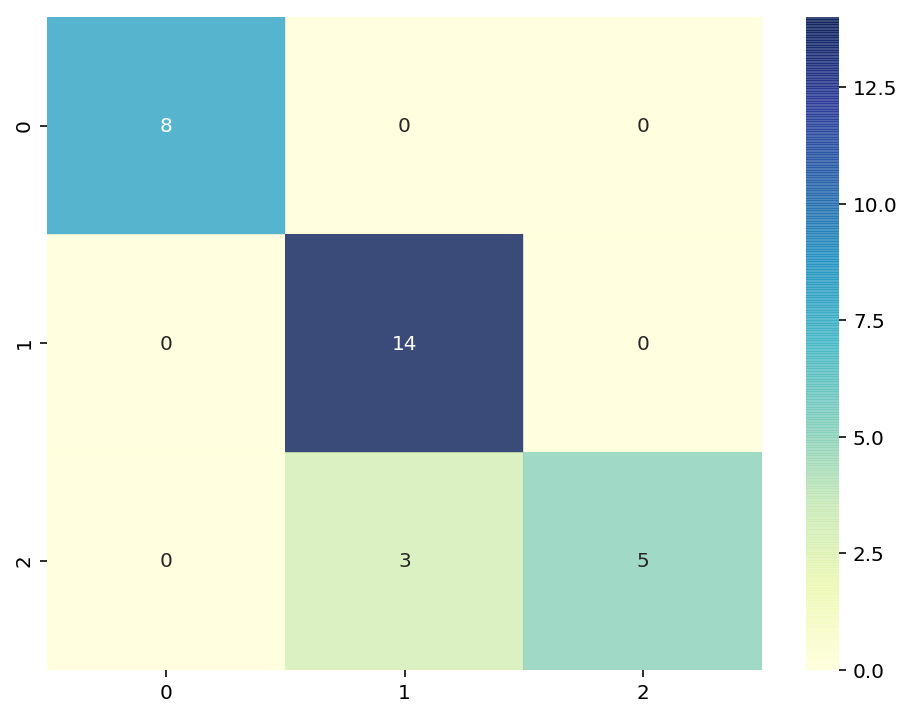

In [62]:
#classification report showing the precision and recall of our model
y_pred_class = deep_model.predict_classes(X_test, verbose=0)
y_test_class = np.argmax(y_test, axis=1)
print(classification_report(y_test_class, y_pred_class))
plot_confusion_matrix(deep_model, X_test, y_test_class)

[1.         1.         0.93333334 0.93333334 0.96666664]
Accuracy: 96.67% (+/- 5.96%)
[0.96666664 0.96666664 0.89999998 0.93333334 0.96666664]
Accuracy: 94.67% (+/- 5.33%)


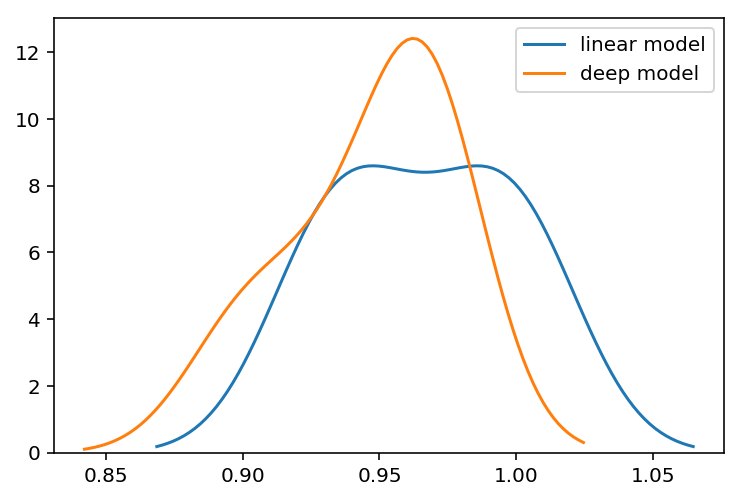

In [66]:
#Cross Validation (get a better estimate on accuracy)
#Using k-fold cross validation
#split the dataset into k disjoint parts, use k-1 parts for training and the other 1 part
#for testing. This way every example appears in both training and test sets.
def get_linear_model():
    model = Sequential()
    model.add(Dense(3, input_shape=(X.shape[1],), activation='softmax'))
    model.compile(Adam(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_deep_model():
    model = Sequential()
    model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cv = StratifiedKFold(n_splits=5, random_state=0)

lin_model = KerasClassifier(build_fn=get_linear_model, epochs=50, verbose=0)
lin_scores = cross_val_score(lin_model, X, dataset['label'].values, cv=cv)
print(lin_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*lin_scores.mean(), 100*lin_scores.std()*2))

deep_model = KerasClassifier(build_fn=get_deep_model, epochs=50, verbose=0)
deep_scores = cross_val_score(deep_model, X, dataset['label'].values, cv=cv)
print(deep_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*deep_scores.mean(), 100*deep_scores.std()*2))

sns.distplot(lin_scores, hist=False, label='linear model')
sns.distplot(deep_scores, hist=False, label='deep model')

#Here’s the plot for 5-fold cross validation accuracy for both models. 
#The deep model is doing slightly better, has a higher accuracy and lower variance.

In [ ]:
#Resources
#https://towardsdatascience.com/applied-deep-learning-part-2-real-world-case-studies-1bb4b142a585